In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, 
from scipy.stats import uniform

#### Data Preprocessing

In [89]:
df = pd.read_csv('../cleaning-preprocessing/flight-delay-dataset.csv')

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

In [91]:
# Remove NAs
df.isna().sum()
df.dropna(inplace=True)

In [92]:
# No duplicates
df.duplicated().value_counts()

False    28818
Name: count, dtype: int64

In [93]:
# Remove TAIL_NUM and TAXI_OUT
df.drop(columns=['TAIL_NUM', 'TAXI_OUT', 'DEP_TIME_M'], inplace=True)

In [94]:
# Convert DEW_POINT to int
df['Dew Point'] = df['Dew Point'].astype(int)

In [95]:
# Encode categorical variables
columns_to_encode = ['OP_UNIQUE_CARRIER', 'DEST', 'Wind', 'Condition']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

In [ ]:
# Remove all values beyond 3 standard deviations from the mean
mean_dep_delay = df_encoded['DEP_DELAY'].mean()
std_dep_delay = df_encoded['DEP_DELAY'].std()
upper_threshold = mean_dep_delay + (3 * std_dep_delay)
df_encoded = df_encoded[df_encoded['DEP_DELAY'] <= upper_threshold]

# Remove all values below 0
df_encoded = df_encoded[df_encoded['DEP_DELAY'] >= 15]



#### Train/Test Split

In [ ]:
# Split 80/20 train-test
X = df_encoded.drop(columns=['DEP_DELAY'])
y = df_encoded['DEP_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Feature Selection

In [98]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

model_selector = SelectFromModel(lasso, prefit=True)
X_train_lasso = model_selector.transform(X_train)
X_test_lasso = model_selector.transform(X_test)

print(f"Selected {X_train_lasso.shape[1]} features using Lasso")

Selected 13 features using Lasso


c:\Users\Yash\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Yash\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


#### Develop and Fit Model

In [99]:
# Build SVR Pipeline (with Feature Selection and Scaling)
svr_pipeline_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('svr', SVR())
])              

#### Hyperparameter Tuning

In [100]:
# Hyperparameter Tuning with RandomizedSearchCV
param_dist_lasso = {
    'svr__C': uniform(0.1, 100),
    'svr__epsilon': uniform(0.01, 0.5),
    'svr__kernel': ['rbf', 'linear']
}

random_search_lasso = RandomizedSearchCV(
    svr_pipeline_lasso,
    param_distributions=param_dist_lasso,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_lasso.fit(X_train_lasso, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D563D8FC90>,
                                        'svr__epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D563E26E10>,
                                        'svr__kernel': ['rbf', 'linear']},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

#### Performance Evaluation

In [ ]:
# Evaluate Best Model on Test Set
best_model_lasso = random_search_lasso.best_estimator_
y_pred_lasso = best_model_lasso.predict(X_test_lasso)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print(" Lasso + SVR Results:")
print("Best Parameters:", random_search_lasso.best_params_)
print("Test MSE:", mse_lasso)
print("Test MAE:", mae_lasso)

🔍 Lasso + SVR Results:
Best Parameters: {'svr__C': np.float64(2.1584494295802448), 'svr__epsilon': np.float64(0.49495492608099717), 'svr__kernel': 'linear'}
Test MSE: 747.7827567489398
Test MAE: 20.211912310157125
Test R²: -0.03156340094875221


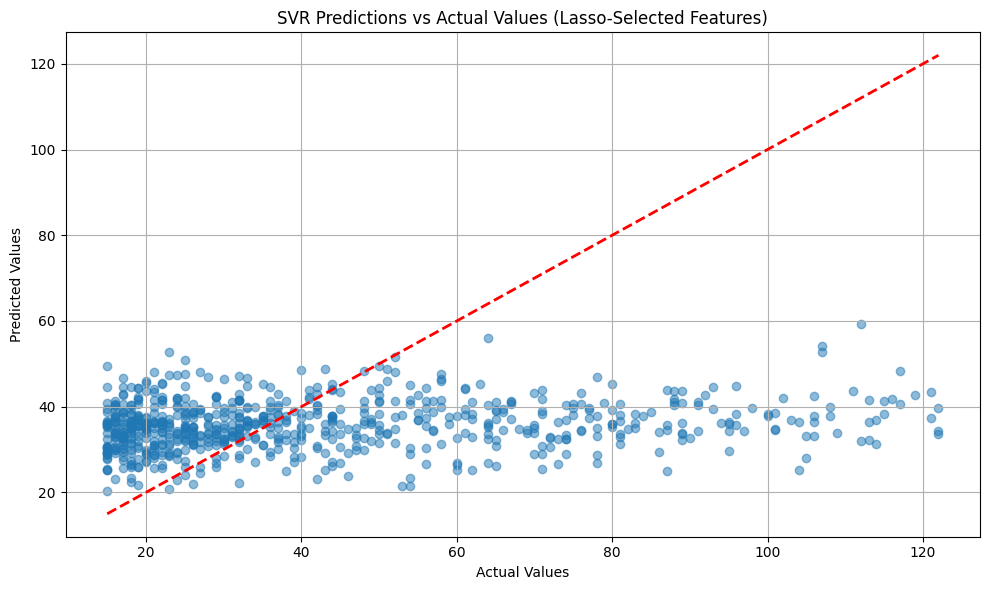

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)

# Identity line (perfect prediction reference)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

# Labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SVR Predictions vs Actual Values (Lasso-Selected Features)")
plt.grid(True)
plt.tight_layout()
plt.show()

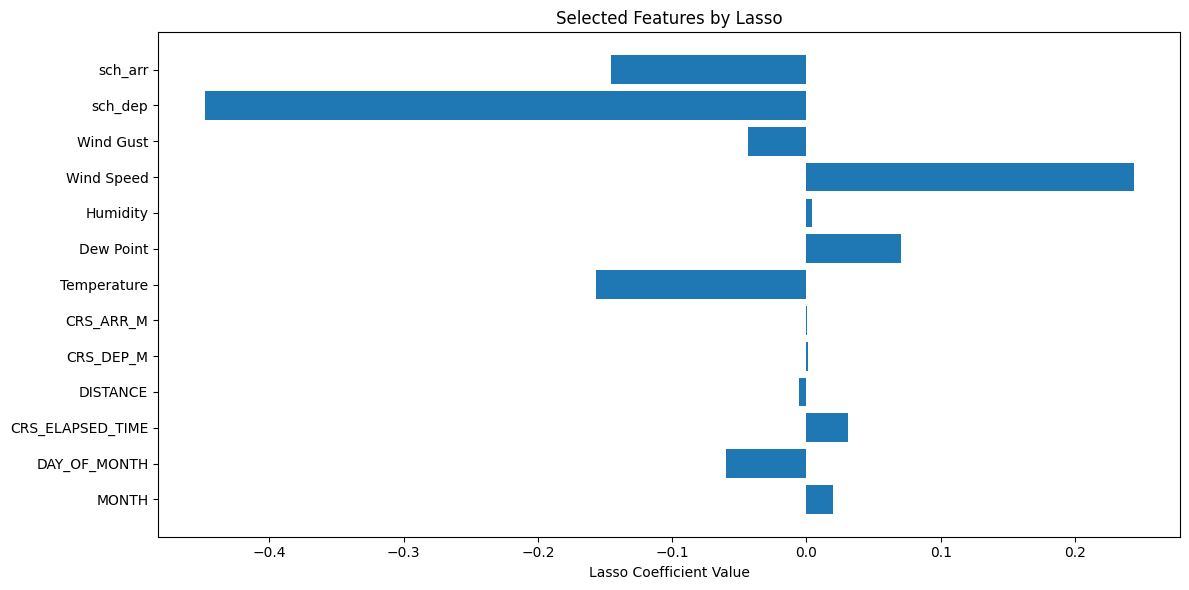

In [102]:
try:
    feature_names = X_train.columns
except:
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

# Get coefficients and mask the non-zero ones
coef = lasso.coef_
non_zero_mask = coef != 0
selected_features = np.array(feature_names)[non_zero_mask]
selected_coefs = coef[non_zero_mask]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(selected_features, selected_coefs)
plt.xlabel("Lasso Coefficient Value")
plt.title("Selected Features by Lasso")
plt.tight_layout()
plt.show()

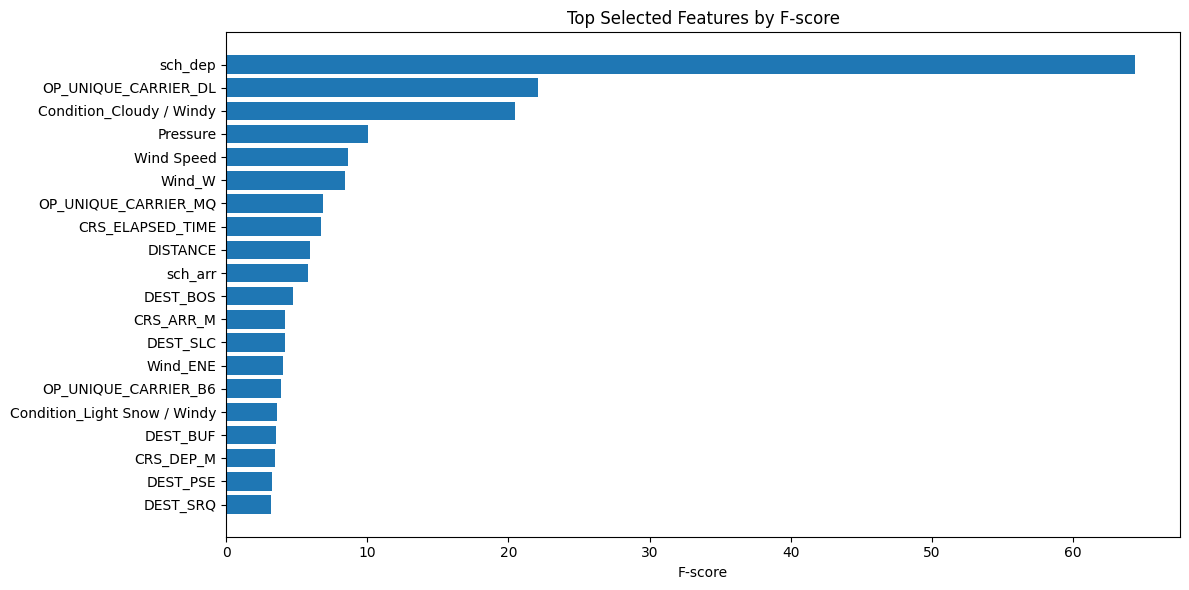

In [103]:
selected_k = best_model.named_steps['select'].k
feature_scores = best_model.named_steps['select'].scores_
feature_indices = np.argsort(feature_scores)[-selected_k:] 

try:
    feature_names = X_train.columns
except:
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

top_features = [feature_names[i] for i in feature_indices]
top_scores = feature_scores[feature_indices]

# Bar plot of top K features
plt.figure(figsize=(12, 6))
plt.barh(top_features, top_scores)
plt.xlabel("F-score")
plt.title("Top Selected Features by F-score")
plt.tight_layout()
plt.show()

#### Model Performance with Other Feature Selection Techniques

In [104]:
svr_pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_regression)),    
    ('scale', StandardScaler()),                          
    ('svr', SVR())               
])

param_dist = {
    'select__k': [10, 20, 'all'],
    'svr__C': uniform(0.1, 100),
    'svr__epsilon': uniform(0.01, 0.5),
    'svr__kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(
    svr_pipeline,
    param_distributions=param_dist,
    n_iter=20, 
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("SVR Test MSE:", mse)
print("SVR Test MAE:", mae)
average_pred_minutes = np.mean(y_pred)
print(f"Average Predicted Time: {average_pred_minutes:.2f} minutes")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'select__k': 20, 'svr__C': np.float64(9.867211400638388), 'svr__epsilon': np.float64(0.35211651325607846), 'svr__kernel': 'rbf'}
SVR Test MSE: 758.7848856386312
SVR Test MAE: 20.569066893595906
Average Predicted Time: 36.25 minutes


In [ ]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)

ridge_selector = SelectFromModel(ridge, prefit=True, threshold='mean') 
X_train_ridge = ridge_selector.transform(X_train)
X_test_ridge = ridge_selector.transform(X_test)

print(f"Selected {X_train_ridge.shape[1]} features using Ridge")

svr_pipeline_ridge = Pipeline([
    ('scale', StandardScaler()),
    ('svr', SVR())
])

param_dist_ridge = {
    'svr__C': uniform(0.1, 100),
    'svr__epsilon': uniform(0.01, 0.5),
    'svr__kernel': ['rbf', 'linear']
}

random_search_ridge = RandomizedSearchCV(
    svr_pipeline_ridge,
    param_distributions=param_dist_ridge,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_ridge.fit(X_train_ridge, y_train)

best_model_ridge = random_search_ridge.best_estimator_
y_pred_ridge = best_model_ridge.predict(X_test_ridge)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print("🔍 Ridge + SVR Results:")
print("Best Parameters:", random_search_ridge.best_params_)
print("Test MSE:", mse_ridge)
print("Test MAE:", mae_ridge)


c:\Users\Yash\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Yash\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected 55 features using Ridge
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🔍 Ridge + SVR Results:
Best Parameters: {'svr__C': np.float64(0.8066305219717406), 'svr__epsilon': np.float64(0.02153121252070788), 'svr__kernel': 'rbf'}
Test MSE: 776.2528683330614
Test MAE: 20.564635516486558
Test R²: -0.0708378090118511
